In [8]:
from xml.dom import minidom
import re
import pandas as pd
import sys
import pickle
import numpy as np
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
ps = PorterStemmer()

In [9]:
f=open('Stopwords.txt')
s_words=f.read()
s_words=s_words.split('\n')
s_words.append('')

f=open('verbs.txt','r')
verbs=f.read()
f.close()
verbs=verbs.split('\n')

irr=pd.read_csv('irr_verbs.txt',delimiter=',',names=['root','past','past_par'])
verb_root=list(irr['root'])
past=list(irr['past'])
past_pp=list(irr['past_par'])


def stem_regular_verb(word):
    if len(word)<=3:
        return word
    if word[-2:]=='es':
        if word[:-2] in verbs:
            word=word[:-2]

    elif word[-1:]=='s':
        if word[:-1] in verbs:
            word=word[:-1]
            
    elif word[-3:]=='ing':
        if word[:-3] in verbs:
            word=word[:-3]
        if word[:-4] in verbs:
            word=word[:-4]
        else:
            word=word[:-3]
    
    elif word[-2:]=='ed':
        if word[:-2] in verbs:
            word=word[:-2]
        elif word[:-1] in verbs:
            word=word[:-1]
    #word=stem_irregular(word)
    return word
def stem_simple(word):
    if word[-2:]=='es':
            word=word[:-2]   
    elif word[-1:]=='s':
            word=word[:-1]
    elif word[-3:]=='ing':
            word=word[:-3]
    
    elif word[-2:]=='ed':
            word=word[:-2]
    return word

def stem_irregular_verb(word):
        if word in past:
            ind=past.index(word)
            word=verb_root[ind]
        elif word in past_pp:
            ind=past_pp.index(word)
            word=verb_root[ind]
        return word
def stem_word(word):
    temp=word
    word=stem_regular_verb(word)
    word=stem_irregular_verb(word)
    #word=ps.stem(word)
    if(len(word)<=1):
        return temp
    return word   
def remove_minor_words(wordmap,word_count,min_occurance):
    words=list(wordmap.keys())
    freq=list(wordmap.values())
    word_df=pd.DataFrame(words,index=list(wordmap.values()),columns=['words'])
    word_df=word_df.sort_index()
    word_df['freq']=wc
    word_df=word_df.sort_values('freq',ascending=False)
    mask=word_df['freq']<=min_occurance
    word_df=word_df[mask]
    
    ss_words=(list(word_df['words']))
    print('initial length of wordmap :',len(wordmap))
    for word in ss_words:
        del wordmap[word]
    
    _wordmap={}
    ind=0
    for word in wordmap.keys():
        _wordmap[word]=ind
        ind+=1
    print('reduced length of wordmap :',len(_wordmap))
    return _wordmap
def remove_tags(doc):
    text=doc.lower()
    #text=re.sub('\n',' ',text)
    #text=re.sub('-',' ',text)
    #text=re.sub('[()?.@*#&!,$]','',text)
    #text=re.sub('[\']','',text)
    #text=re.sub('[^a-z0-9]',' ',text)
    #words=text.split(' ')
    text=re.sub('<[^<>]+>',' ',text)
    words=re.findall('\w+',text)
    return words
def pre_process(topics,max_doc,root):
    index=0
    labels=[]
    ln=0
    labeled_docs={}
    for topic in topics:
        print(topic)
        mydoc = minidom.parse(root+topic+'.xml')
        documents = mydoc.getElementsByTagName('row')
        doc_count=0
        docs=[]
        for doc in documents:
            doc=doc.attributes['Body'].value
            if len(doc)<5:
                continue
            words = remove_tags(doc)
            ln+=len(words)
            docs.append(words)
            labels.append(topic)
            doc_count+=1
            if doc_count>=max_doc:
                break
        labeled_docs[topic]=docs
    return labeled_docs,ln

In [10]:
root='Dataset/Training/'
root_test='Dataset/Test/'
f=open('Stopwords.txt')
s_words=f.read()
s_words=s_words.split('\n')
s_words.append('')
max_docs_train=200
max_docs_test=60
log=False
root='Dataset/Training/'
#topics=['3d_Printer','Anime','Arduino']
topics=['3d_Printer','Coffee','Chess']
#topics=['3d_Printer','Coffee','Chess','Astronomy','Law']
train_docs,ln=pre_process(topics,max_docs_train,root)
test_docs,ln=pre_process(topics,max_docs_test,root_test)
print(ln)


3d_Printer
Coffee
Chess
3d_Printer
Coffee
Chess
26024


In [11]:
def make_dictionary(topics,max_doc,all_docs):
    index=0
    wordmap={}
    word_count=[]
    for topic in topics:
        print(topic)
        doc_count=0
        docs=all_docs[topic]
        for doc in docs:
            for word in doc:
                if word in s_words or len(word)<=1:
                    continue
                word=stem_word(word)
                if word not in wordmap:
                    wordmap[word]=index
                    word_count.append(int(1))
                    index=index+1
                elif word in wordmap:
                    ind=wordmap[word]
                    word_count[ind]=int(word_count[ind])+1
    return wordmap,word_count

def vectorize_seq_nb(topics,max_doc,wordmap,all_docs,doc_per_vect='all'):
    if doc_per_vect=='single':
        n_row=len(topics)*(max_doc)
    if doc_per_vect=='all':
        n_row=len(topics)
    vectors=np.zeros((n_row,len(wordmap)),dtype=np.float64)
    vct_label=[]
    row=0
    for topic in topics:
        print(topic)
        doc_count=0
        docs=all_docs[topic]
        for doc in docs:
            for word in doc:
                #word=ps.stem(word)
                if word in wordmap:
                    ind=wordmap[word]
                    vectors[row,ind]=vectors[row,ind]+1
            word_list.append(doc)
            if doc_per_vect=='single':
                vct_label.append(topic)
                row=row+1
        if doc_per_vect=='all':
            vct_label.append(topic)
            row=row+1
    return vectors,vct_label

In [12]:
word_list=[]
min_occurance=int(max_docs_train/200)
print('Making dictionary :')
wordmap,wc=make_dictionary(topics,max_docs_train,train_docs)
#print('Removing minor words:')
#wordmap=remove_minor_words(wordmap,wc,min_occurance)
print('Vectorizing Sequence:')
vectors,vct_labels=vectorize_seq_nb(topics,max_docs_train,wordmap,train_docs)
print(len(wordmap))

Making dictionary :
3d_Printer
Coffee
Chess
Vectorizing Sequence:
3d_Printer
Coffee
Chess
5999


In [20]:
test_vectors,true_lbs=vectorize_seq_nb(topics,max_docs_test,wordmap,test_docs,doc_per_vect='single')
def nb(test_vector,vectors,vct_labels,alpha):
    probs=[]
    maxm=0
    lb=''
    vct=0
    _vectors=vectors.copy()
    total_word_all=np.sum(_vectors)#len(wordmap)
    for row in range(len(_vectors)):
        total_word=np.sum(_vectors[row])
        _vectors[row]=_vectors[row]+alpha
        _vectors[row]=_vectors[row]/(total_word+alpha*total_word_all)
    #norm_value=np.mean(_vectors)
    norm_value=(1000.0-0)/(np.max(_vectors)-np.min(_vectors))
    for row in range(len(_vectors)):
        vect=_vectors[row].copy()
        vect=np.exp(vect)
        #vect=vect*norm_value#1000#total_word_all#np.sum(_vectors)
        vect[test_vector==0]=1.0
        #test_vector_zero_mask=np.array(test_vector==0,dtype=np.uint8)
        #test_vector_one_mask=np.array(test_vector!=0,dtype=np.uint8)
        #vect=test_vector_one_mask*vectors[row]+test_vector_zero_mask
        prob=np.prod(vect)
        #prob=1
        #for p in range(len(vect)):
        #    if vect[p]!=1:
        #        prob*=(vect[p]*1000)
        #prob=np.sum(vect)
        probs.append(prob)
        if prob>=maxm:
            maxm=prob
            lb=vct_labels[row]
    return probs,lb
print(len(test_vectors))

3d_Printer
Coffee
Chess
180


In [21]:
import time
alph=10
no_topics=len(topics)
tot_doc=no_topics*max_docs_train
tot_doc_test=no_topics*max_docs_test
acc_log=''
acc_log+='******************************************************************\n'
acc_log+=str(topics)+'\n'
acc_log+=str(['no_topic','train doc per topic','train_doc','test doc per topic','test_doc','word map'])+'\n'
acc_log+=str([no_topics,max_docs_train,tot_doc,max_docs_test,tot_doc_test,str(len(wordmap))])+'\n'
acc_log+='******************************************************************\n'
head=acc_log
acc_log+=str(['alpha','accuracy','time'])+'\n'
lst=np.array([1,2,3,4,5,6,7,8,9,10],dtype=np.float64)


acc_list=[]
alph_list=[]
alpha_list=np.concatenate((lst/100000,lst/10000,lst/1000,lst/100,lst/10))
alpha_list=np.round(alpha_list,5)
#alpha_list=[.000001]
for al in alpha_list:
    T=time.time()
    acc=0
    alpha=al
    for i in range(len(test_vectors)):
        pred,pred_label=nb(test_vectors[i],vectors,vct_labels,alpha)
        #print(true_lbs[i],pred_label)
        #print(pred)
        if pred_label==true_lbs[i]:
            acc=acc+1
        else:
            print('no')
            print(pred)
        #print('res','pred',lb,'true',true_lbs[i],i+1,acc)
    T=time.time()-T
    accuracy=acc/(i+1)
    acc_list.append(accuracy)
    alph_list.append(alpha)
    print('alpha: ',alpha,'acc :',accuracy)
    acc_log+=(str([alpha,accuracy,T])+'\n')
acc_log=re.sub('[\[\]]','',acc_log)
acc_list=np.array(acc_list,dtype=np.float64)
alpha_list=np.array(alpha_list,dtype=np.float64)
max_acc=np.max(acc_list)
avg_acc=np.mean(acc_list)
max_alpha=alph_list[np.argmax(acc_list)]
head+=str(['alpha','accuracy','avg_acc'])+'\n'
result=(str([max_alpha,max_acc,avg_acc])+'\n')
if log==True:
    f=open('NB/NB_mod.csv','a')
    f.write(head+result)
    f.close()
    f=open('Report_KNN_NB/NB_topic_2_200_60_no_corr.txt','a')
    f.write(acc_log)
    f.close()

    #print(pred)

no
[1.0020210227023532, 1.0011961979601642, 1.0041400935429703]
no
[1.0196104931915255, 1.0170646264123862, 1.0241730500976014]
no
[1.0019246911091693, 1.001656653948506, 1.0025855550850984]
no
[1.0289657426033174, 1.0241035661291953, 1.0221914897491868]
no
[1.007430411704748, 1.0055328653758766, 1.0062165771675102]
alpha:  1e-05 acc : 0.9722222222222222
no
[1.0020209691496824, 1.0011961687812645, 1.0041399419966128]
no
[1.0196099583810774, 1.0170641839955998, 1.0241721573591924]
no
[1.0019246402491313, 1.0016566124655932, 1.0025854619713974]
no
[1.0289649377167231, 1.0241029293351172, 1.0221906689491693]
no
[1.007430218158961, 1.0055327311875986, 1.0062163630177796]
alpha:  2e-05 acc : 0.9722222222222222
no
[1.0020209156000026, 1.0011961396039224, 1.0041397904616332]
no
[1.0196094236007525, 1.0170637416026163, 1.0241712646884529]
no
[1.0019245893919335, 1.0016565709848955, 1.002585368864682]
no
[1.02896413287567, 1.0241022925754195, 1.0221898482113125]
no
[1.0074300246240093, 1.005532

no
[1.0286481686428735, 1.0238521863184897, 1.0218688531509657]
no
[1.0073540379131976, 1.0054798883321105, 1.006132390356977]
alpha:  0.004 acc : 0.9722222222222222
no
[1.0019946664641075, 1.0011818287552214, 1.0040658597781935]
no
[1.0193473137678764, 1.016846779150055, 1.0237358263958976]
no
[1.001899660048228, 1.0016362256705917, 1.0025399434401807]
no
[1.0285696841749778, 1.0237900213383215, 1.0217894915345078]
no
[1.007335160336118, 1.005466785796517, 1.0061116792310747]
alpha:  0.005 acc : 0.9722222222222222
no
[1.00198947155503, 1.0011789944866687, 1.0040513104643918]
no
[1.0192954473579543, 1.0168038147843321, 1.0236501516106937]
no
[1.0018947263324514, 1.001632196288557, 1.0025310037154946]
no
[1.028491636396663, 1.023728186679335, 1.021710717662934]
no
[1.007316386716715, 1.00545375226295, 1.0060911203206864]
alpha:  0.006 acc : 0.9722222222222222
no
[1.0019843051061372, 1.0011761750765655, 1.0040368676031108]
no
[1.0192438674476554, 1.0167610773366533, 1.0235651095433183]
n

no
[1.0314341192923302, 1.028567800338201, 1.0275116120056034]
no
[1.019332669377994, 1.0178055750435915, 1.018227485725911]
no
[1.0033978353893853, 1.0026626940630603, 1.0024969337727583]
alpha:  0.5 acc : 0.9555555555555556
no
[1.000820096639138, 1.0005233639452542, 1.0013444654123116]
no
[1.007680442851975, 1.0069105676560324, 1.007813489220683]
no
[1.0007841133901212, 1.00070023798159, 1.0008669335855356]
no
[1.0110627945160617, 1.0095196783757387, 1.0071406898219102]
no
[1.0073761521377536, 1.0057934266864301, 1.007276815343775]
no
[1.0283008839684413, 1.0257882679957118, 1.024511510630005]
no
[1.0174005823797907, 1.016064887488676, 1.0162211053353003]
no
[1.0030968646515586, 1.0024423469813197, 1.0022683397571366]
alpha:  0.6 acc : 0.9555555555555556
no
[1.000752358412842, 1.0004842777992289, 1.0012160351116974]
no
[1.0070112789905399, 1.0063236167259362, 1.007067159050001]
no
[1.0007197770660194, 1.0006446863666167, 1.0007879363324972]
no
[1.0100616767560768, 1.0086785864856727,

In [22]:
print(head)
print(result)

******************************************************************
['3d_Printer', 'Coffee', 'Chess']
['no_topic', 'train doc per topic', 'train_doc', 'test doc per topic', 'test_doc', 'word map']
[3, 200, 600, 60, 180, '5999']
******************************************************************
['alpha', 'accuracy', 'avg_acc']

[1e-05, 0.9722222222222222, 0.9692222222222222]



In [19]:
np.exp(1)

2.718281828459045

In [19]:
1.0e-323==0.0

False

In [13]:
words=list(wordmap.keys())
freq=list(wordmap.values())
word_df=pd.DataFrame(words,index=list(wordmap.values()))
word_df=word_df.sort_index()
word_df['freq']=wc
word_df=word_df.sort_values('freq',ascending=False)
print(word_df[0:50])
#print(len(vectors))

              0  freq
3033     coffee   560
39        print   323
10          use   181
2557      chess   163
417       water   157
40         time   141
15      printer   127
2132       game   124
3148   caffeine   120
4926       king   119
81     filament   115
366        open   115
138        make   108
3035      beans   105
889       moves   105
14           3d   103
3043       brew   103
292        good   100
4933     player    97
525         way    97
3106      roast    92
0            ve    89
4917       pawn    87
26         need    86
254        play    85
73          abs    84
3037   espresso    82
2797      white    80
173       parts    78
691     machine    76
2209        cup    76
32         know    74
83     material    74
74          pla    72
351     process    72
23          say    72
34        layer    71
160         don    71
90    different    66
5023      queen    66
163      better    65
2798      black    65
144        work    64
1       printed    63
129       

[35. 63. 16. ...  0.  0.  0.]


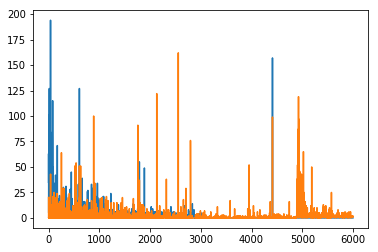

['3d_Printer', 'Coffee', 'Chess']
5999


In [56]:
from matplotlib import pyplot as plt
print((vectors[0]))
x=range(len(vectors[0]))
plt.plot(x,vectors[0])
plt.plot(x,vectors[2])
#plt.plot(x,vectors[2])
plt.show()
print(vct_labels)
print(len(wordmap))
#no stem 500 20599 
#stem 500 14883

In [18]:
def eucl_dis(test_vector,vectors):
    h_dists=[]
    for vector in vectors:
        vect=np.array(vector[:-2])
        vect[vect>1]=1
        label=vector[-1]
        test_vect=np.array(test_vector)
        dist=np.abs(vect-test_vect)
        #dist=np.sum(dist)
        h_dists.append([dist,label])
    return h_dists

test_vector=vectors[0][:-2]
vecto=[vectors[0],vectors[1]]
h_dists=cos_dis(test_vector,vecto)
#h_df=pd.DataFrame(h_dists)
#h_df=h_df.sort_values(0)
print(h_dists)
#print((vectors[15]))

NameError: name 'cos_dis' is not defined

In [109]:
raw='I am hasib\n,i "am" a student() so? @i do& my-duties! porp. and' 
#text=re.sub('\n',' ',raw)
text=raw.lower()
text=re.sub('[^a-z0-9]',' ',text)
#text=re.sub('-',' ',text)
#text=re.sub('[\'"]','',text)
#text=re.sub('[()?.@*#&!,$+]','',text)
#print(text.split(' '))

In [27]:
txt=(str([1,2,3]))
txt=re.sub('[\[\]]','',txt)
print(txt)

1, 2, 3
